### CLASH demo (borrowed from Running Eazy-py on the Riverside test catalogs)

In [7]:
%matplotlib inline
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.table import Table

from astropy.utils.exceptions import AstropyWarning
import warnings
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

### Prepare catalogs

In [16]:
#file    = '/Users/brianmerino/EAZY/catalogs/galaxy_w_ampli2.cat' 
#newfile = '/Users/brianmerino/EAZY/catalogs/galaxy_w_ampli2_flux.fits'

file    = '/Users/brianmerino/Desktop/catalogs/Galaxy_Full.cat' 
newfile = '/Users/brianmerino/EAZY/catalogs/Galaxy_Full_flux.fits'

#file    = '/Users/brianmerino/Desktop/catalogs/macs1720_1535.cat' 
#newfile = '/Users/brianmerino/EAZY/catalogs/macs1720_1535_flux.fits'

cat = Table.read(file, format='ascii')
print(cat) 

abzp = 23.9 # microJy
    
for magerr_col in cat.colnames:
    if magerr_col.endswith('_magerr'):
        mag_col = magerr_col[:-3]
         
        flux_col = mag_col.replace("_mag","_flux")
        fluxerr_col = magerr_col.replace("_magerr","_fluxerr")
            
        ###############################################################
        # Replace flux_err with 20% of flux if the magnitudes do not have errors
        for i in range(0,len(cat[magerr_col])):
            flux = 10**(-0.4*(cat[mag_col][i]-abzp))
            
            if np.isinf(cat[magerr_col][i]):
                flux_err = flux*0.2
            elif cat[magerr_col][i] == -99:
                flux_err = flux*0.2
            else:
                flux_err = np.log(10)*flux*cat[magerr_col][i]/2.5 
            
            #flux /= cat['AMP_500'][i]
            #flux_err /= cat['AMP_500'][i]
            
            flux_best     = flux     / cat['AMP_best'][i]
            flux_best_err = flux_err / cat['AMP_best'][i]
            
            flux_16       = flux     / cat['AMP_16'][i]
            flux_16_err   = flux_err / cat['AMP_16'][i]
            
            flux_84       = flux     / cat['AMP_84'][i]
            flux_84_err   = flux_err / cat['AMP_84'][i]
            
            bad  = cat[mag_col][i] < -90
            bad |= cat[mag_col][i] > 90

            if bad:
                flux_best     = -99
                flux_best_err = -99
                
                flux_16       = -99
                flux_16_err   = -99
                
                flux_84       = -99
                flux_84_err   = -99

            
            if i == 0:
                cat[flux_col+'_best']       = flux_best
                cat[fluxerr_col+'_best']    = flux_best_err
                
                cat[flux_col+'_16']         = flux_16
                cat[fluxerr_col+'_16']      = flux_16_err
                
                cat[flux_col+'_84']         = flux_84
                cat[fluxerr_col+'_84']      = flux_84_err
            
            else:
                cat[flux_col+'_best'][i]    = flux_best
                cat[fluxerr_col+'_best'][i] = flux_best_err
                
                cat[flux_col+'_16'][i]      = flux_16
                cat[fluxerr_col+'_16'][i]   = flux_16_err
                
                cat[flux_col+'_84'][i]      = flux_84
                cat[fluxerr_col+'_84'][i]   = flux_84_err
            
###########################################################################################################
#- eazy seems to have z_spec hard coded in it, whether we use it or not (GLW 3/23/21)
#- eazy has a error in the code, you need at least two objects in the catalog (this is why the prior fails)
###########################################################################################################

cat['z_spec'] = cat['z_eazy']
print(cat.colnames)

cat.write(newfile, overwrite=True)            
#cat.write(file, overwrite=True,format='ascii')
cat.show_in_notebook()
#cat[31:51].show_in_notebook()

cluster  id       RA     ...       LIR_16             LIR_84      
------- ---- ----------- ... ------------------ ------------------
   a209  218  22.9730375 ...  39699231506.46507  39455138450.16757
   a209 1020   22.978325 ...   8129506017.64603  7736711057.498987
   a209 1312    22.97045 ... 3191504609.3553076 3191504609.3553076
   a209 1602    22.96975 ...  987825100.5486308  948692449.6661325
   a209 1669  22.9816125 ...  58794424569.04814  58604081032.26416
   a209 1671   22.979675 ... 3365515277.4816403 3298695165.2565355
   a209 1708  22.9617583 ... 1247064887.1357925  1235087146.504485
   a209 1772  22.9806292 ... 262250838.83640438 244650126.37439966
   a383   58  42.0155833 ... 13117123599.776936 11301102383.267893
   a383  128  42.0005042 ... 19673954187.430435  19039416091.44845
    ...  ...         ... ...                ...                ...
rxj2129  246 322.4055333 ...  8101294879.647619  8065086614.089996
rxj2129  259 322.4223833 ...  89575937870.40614  88898381220.7

idx,cluster,id,RA,DEC,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,z_eazy,z_connor_phot,z_connor_spec,z_MUSE,z_spec_other,z_16,z_50,z_84,AMP_16,AMP_best,AMP_84,flag_spec,ra_sexagesimal,dec_sexagesimal,f225w_flux_best,f225w_fluxerr_best,f225w_flux_16,f225w_fluxerr_16,f225w_flux_84,f225w_fluxerr_84,f275w_flux_best,f275w_fluxerr_best,f275w_flux_16,f275w_fluxerr_16,f275w_flux_84,f275w_fluxerr_84,f336w_flux_best,f336w_fluxerr_best,f336w_flux_16,f336w_fluxerr_16,f336w_flux_84,f336w_fluxerr_84,f390w_flux_best,f390w_fluxerr_best,f390w_flux_16,f390w_fluxerr_16,f390w_flux_84,f390w_fluxerr_84,f435w_flux_best,f435w_fluxerr_best,f435w_flux_16,f435w_fluxerr_16,f435w_flux_84,f435w_fluxerr_84,f475w_flux_best,f475w_fluxerr_best,f475w_flux_16,f475w_fluxerr_16,f475w_flux_84,f475w_fluxerr_84,f606w_flux_best,f606w_fluxerr_best,f606w_flux_16,f606w_fluxerr_16,f606w_flux_84,f606w_fluxerr_84,f625w_flux_best,f625w_fluxerr_best,f625w_flux_16,f625w_fluxerr_16,f625w_flux_84,f625w_fluxerr_84,f775w_flux_best,f775w_fluxerr_best,f775w_flux_16,f775w_fluxerr_16,f775w_flux_84,f775w_fluxerr_84,f814w_flux_best,f814w_fluxerr_best,f814w_flux_16,f814w_fluxerr_16,f814w_flux_84,f814w_fluxerr_84,f850lp_flux_best,f850lp_fluxerr_best,f850lp_flux_16,f850lp_fluxerr_16,f850lp_flux_84,f850lp_fluxerr_84,f105w_flux_best,f105w_fluxerr_best,f105w_flux_16,f105w_fluxerr_16,f105w_flux_84,f105w_fluxerr_84,f110w_flux_best,f110w_fluxerr_best,f110w_flux_16,f110w_fluxerr_16,f110w_flux_84,f110w_fluxerr_84,f125w_flux_best,f125w_fluxerr_best,f125w_flux_16,f125w_fluxerr_16,f125w_flux_84,f125w_fluxerr_84,f140w_flux_best,f140w_fluxerr_best,f140w_flux_16,f140w_fluxerr_16,f140w_flux_84,f140w_fluxerr_84,f160w_flux_best,f160w_fluxerr_best,f160w_flux_16,f160w_fluxerr_16,f160w_flux_84,f160w_fluxerr_84,Av_best,Av_16,Av_84,sfr_best,sfr_16,sfr_84,mass_best,mass_16,mass_84,LIR_best,LIR_16,LIR_84,z_spec
0,a209,218,22.9730375,-13.5973175,0.939,21.022,0.025,-99.0,-99.0,22.711,0.068,24.107,0.13,24.274,0.114,24.094,0.068,23.743,0.033,23.941,0.068,22.948,0.034,22.67,0.02,22.769,0.06,22.679,0.015,22.58,0.008,22.393,0.012,22.3,0.009,22.298,0.014,0.8485,0.903,-99.99,-99.99,-99.99,0.8221,0.8638,0.9,1.2121,1.2149,1.2196,0.0,01:31:53.529,-13:35:50.34,11.658950755111643,0.2684572620867175,11.685883402677284,0.26907740921471257,11.61402039388745,0.26742270228694087,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.4607045253227318,0.15411469838497427,2.466388852251949,0.15447070956843928,2.451221652848956,0.15352078309929915,0.6802357739038563,0.08144763914103895,0.6818071460405867,0.0816357864800332,0.6776143339749058,0.08113376253890475,0.5832563395479197,0.06124067928938149,0.5846036852708255,0.06138214773423775,0.581008631450285,0.06100467470373038,0.6884294934431013,0.04311655570568315,0.6900197934032043,0.04321615669238055,0.6857764771925418,0.04295039646345889,0.9511728993350307,0.028910066313067737,0.9533701471843321,0.02897684973496081,0.9475073429010568,0.0287986549391161,0.7926098551086965,0.049641404524589997,0.7944408159158118,0.0497560781758307,0.7895553566509966,0.04945010032545456,1.978151127609877,0.061946113654484575,1.9827207366828148,0.06208921168124191,1.9705278820377499,0.06170739052052584,2.555403397916163,0.04707227016502472,2.56130648306934,0.04718100901203576,2.5455555822633213,0.04689086669685842,2.3327031076706697,0.12890993765048084,2.3380917461505626,0.12920772481772888,2.323713517144225,0.12841315451916135,2.534308428464574,0.03501276485059017,2.5401627833855382,0.03509364575281083,2.524541906970819,0.03487783536977861,2.7762557301742445,0.02045620818764325,2.7826689931430493,0.020503462855513396,2.76555681091234,0.020377375637231705,3.2980669535123086,0.03645158305369789

In [17]:
# Link templates and filter files 
# EAZYCODE is an environment variable that points to the the eazy-photoz distribution
#eazy.symlink_eazy_inputs(path='EAZYCODE', path_is_env=True)

eazy.symlink_eazy_inputs()


/Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/data/templates -> ./templates
/Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [13]:
cat[0]['f125w_magerr']

0.0

### Run the photo-z fits

In [18]:
print('\n####\n')
params = {}

#translate_file = 'zphot.translate_nouvis.clash'
#translate_file = 'zphot.translate.clash'

#The available modes are: '16', '84', and 'best'
mode = '84'

print('Using the translate file for %s \n'%(mode))
translate_file = 'zphot.translate_390w.clash_%s'%(mode)

#translate_file = 'zphot.translate_390w.clash_best'
#translate_file = 'zphot.translate_390w.clash_16'
#translate_file = 'zphot.translate_390w.clash_84'


params['CATALOG_FILE'] = newfile
params['MAIN_OUTPUT_FILE'] = 'galaxy_Phot_no_uvis_info.eazypy'

params['PRIOR_FILTER'] = 205
params['PRIOR_ABZP'] = abzp
#params['MW_EBV'] = EBV

# Galactic extinction
params['MW_EBV'] = 0.0 # already accounted for in CLASH
#params['MW_EBV'] = 0.0161 # a209      S & F mean
#params['MW_EBV'] = 0.0170 # a1423     S & F mean
#params['MW_EBV'] = 0.0357 # macs0416  S & F mean
#params['MW_EBV'] = 0.0265 # macs1311  S & F mean
#params['MW_EBV'] = 0.0235 # macs1423  S & F mean

params['Z_MAX'] = 3.0
params['Z_STEP'] = 0.01
params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
params['VERBOSITY'] = 1

###############################################################
#Fix z_phot for clumps
params['FIX_ZSPEC'] = 'n'
###############################################################

print(params)

ez = eazy.photoz.PhotoZ(param_file=None,
                        translate_file=translate_file,
                        zeropoint_file=None, params=params,
                        load_prior=True, load_products=False)

for iter in range(2):
    ez.fit_parallel(n_proc=4)
    ez.error_residuals()

print('Get physical parameters')
ez.standard_output()
#zout.show_in_notebook()


####

Using the translate file for 84 

{'CATALOG_FILE': '/Users/brianmerino/EAZY/catalogs/Galaxy_Full_flux.fits', 'MAIN_OUTPUT_FILE': 'galaxy_Phot_no_uvis_info.eazypy', 'PRIOR_FILTER': 205, 'PRIOR_ABZP': 23.9, 'MW_EBV': 0.0, 'Z_MAX': 3.0, 'Z_STEP': 0.01, 'TEMPLATES_FILE': 'templates/fsps_full/tweak_fsps_QSF_12_v3.param', 'VERBOSITY': 1, 'FIX_ZSPEC': 'n'}
Read default param file: /Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/brianmerino/EAZY/catalogs/Galaxy_Full_flux.fits
   >>> NOBJ = 161
f390w_flux_84 f390w_fluxerr_84 (210): hst/wfc3/UVIS/f390w.dat
f435w_flux_84 f435w_fluxerr_84 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f475w_flux_84 f475w_fluxerr_84 (234): hst/ACS_update_sep07/wfc_f475w_t81.dat
f606w_flux_84 f606w_fluxerr_84 (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f625w_flux_84 f625w_fluxerr_84 (237): hst/ACS_update_sep07/wfc_f625w_t81.dat
f775w_flux_84 f775w_fluxerr_84 (238): hst/ACS_update_sep07/wfc_f775

138it [00:00, 7499.14it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=151)
Fit 1.3 s (n_proc=4, NOBJ=161)
`error_residuals`: force uncertainties to match residuals
Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=151)
Fit 1.2 s (n_proc=4, NOBJ=161)
`error_residuals`: force uncertainties to match residuals
Get physical parameters
Get best fit coeffs & best redshifts
fit_best: 0.3 s (n_proc=1,  NOBJ=154)
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])


/Users/brianmerino/anaconda3/lib/python3.7/site-packages/eazy/photoz.py:4445: RuntimeWarning: covariance is not positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Abs Mag filters [271, 272, 274]
Rest-frame filters: [271, 272, 274]


(<Table length=161>
   id   z_spec ...                ABSM_274 [5]               
               ...                                           
 int64 float64 ...                  float64                  
 ----- ------- ... ------------------------------------------
   218  0.8485 ... -18.683136210791346 .. -18.889805064551112
  1020  0.5941 ...  -18.99229769086685 .. -19.074351829050443
  1312    0.59 ... -18.897909745321293 .. -19.054941758260746
  1602  0.3954 ... -17.740023411785856 .. -17.975821293865934
  1669  0.8485 ...  -20.74966620165914 .. -20.799930560179646
  1671  0.4548 ... -18.984351579231557 .. -19.093503419441518
  1708  0.6995 ... -18.044961877230456 .. -18.191480584505847
  1772  0.4791 ...  -16.122228601418513 .. -16.37988279148199
    58  0.4042 ...   -17.66687545540465 .. -18.21892509224547
   ...     ... ...                                        ...
   259  0.7169 ...  -18.63223902382589 .. -19.115002314231162
   274   0.675 ... -21.186303075174607 .. -21.3559

In [19]:
# Outputs for the z=1 catalog
zout = Table.read('{0}.zout.fits'.format(params['MAIN_OUTPUT_FILE']))
zout['ssfr'] = zout['sfr']/zout['mass']
print(zout.colnames)

['id', 'z_spec', 'nusefilt', 'lc_min', 'lc_max', 'z_phot', 'z_phot_chi2', 'z_phot_risk', 'z_min_risk', 'min_risk', 'z_raw_chi2', 'raw_chi2', 'z025', 'z160', 'z500', 'z840', 'z975', 'restU', 'restU_err', 'restB', 'restB_err', 'restV', 'restV_err', 'restJ', 'restJ_err', 'dL', 'mass', 'sfr', 'Lv', 'LIR', 'MLv', 'Av', 'mass_p', 'sfr_p', 'Lv_p', 'LIR_p', 'ssfr_p', 'rest270', 'rest270_err', 'rest274', 'rest274_err', 'rest120', 'rest120_err', 'rest121', 'rest121_err', 'rest156', 'rest156_err', 'rest157', 'rest157_err', 'rest158', 'rest158_err', 'rest159', 'rest159_err', 'rest160', 'rest160_err', 'rest161', 'rest161_err', 'rest162', 'rest162_err', 'rest163', 'rest163_err', 'DISTMOD', 'ABSM_271', 'ABSM_272', 'ABSM_274', 'ssfr']


In [27]:
print(zout['z_phot','z_spec','z160','z500','z840'][1])
print(cat['z_eazy'][1])

  z_phot  z_spec   z160     z500     z840  
--------- ------ -------- -------- --------
0.5929461 0.5941   0.5360   0.5811   0.6034
0.5941


In [25]:
for y in range(0,len(cat)):
    cat['Av_%s'%(mode)][y]   = zout['Av'][y]
    cat['sfr_%s'%(mode)][y]  = zout['sfr'][y]
    cat['mass_%s'%(mode)][y] = zout['mass'][y]
    cat['LIR_%s'%(mode)][y]  = zout['LIR'][y]
    
    if mode == 'best':
        cat['z_%s'%(mode)][y]= round(zout['z500'][y],4)
    
    elif mode == '16':
        cat['z_%s'%(mode)][y]= round(zout['z160'][y],4)
        
    elif mode == '84':
        cat['z_%s'%(mode)][y]= round(zout['z840'][y],4)

####
#Save Lv
#Save uv, uverr
#Save vj, vjerr
####

#cat.add_column(-99.0,name='LIR_best')
#cat.add_column(-99.0,name='LIR_16')
#cat.add_column(-99.0,name='LIR_84')
#cat.remove_columns(['Av','sfr','mass','LIR'])

cat[:110].show_in_notebook()
#cat.write(file,format='ascii.commented_header')

idx,cluster,id,RA,DEC,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,z_phot,z_eazy,z_conner,z_16,z_best,z_84,z_spec,AMP_16,AMP_best,AMP_84,flag_spec,ra_sexagesimal,dec_sexagesimal,f225w_flux_best,f225w_fluxerr_best,f225w_flux_16,f225w_fluxerr_16,f225w_flux_84,f225w_fluxerr_84,f275w_flux_best,f275w_fluxerr_best,f275w_flux_16,f275w_fluxerr_16,f275w_flux_84,f275w_fluxerr_84,f336w_flux_best,f336w_fluxerr_best,f336w_flux_16,f336w_fluxerr_16,f336w_flux_84,f336w_fluxerr_84,f390w_flux_best,f390w_fluxerr_best,f390w_flux_16,f390w_fluxerr_16,f390w_flux_84,f390w_fluxerr_84,f435w_flux_best,f435w_fluxerr_best,f435w_flux_16,f435w_fluxerr_16,f435w_flux_84,f435w_fluxerr_84,f475w_flux_best,f475w_fluxerr_best,f475w_flux_16,f475w_fluxerr_16,f475w_flux_84,f475w_fluxerr_84,f606w_flux_best,f606w_fluxerr_best,f606w_flux_16,f606w_fluxerr_16,f606w_flux_84,f606w_fluxerr_84,f625w_flux_best,f625w_fluxerr_best,f625w_flux_16,f625w_fluxerr_16,f625w_flux_84,f625w_fluxerr_84,f775w_flux_best,f775w_fluxerr_best,f775w_flux_16,f775w_fluxerr_16,f775w_flux_84,f775w_fluxerr_84,f814w_flux_best,f814w_fluxerr_best,f814w_flux_16,f814w_fluxerr_16,f814w_flux_84,f814w_fluxerr_84,f850lp_flux_best,f850lp_fluxerr_best,f850lp_flux_16,f850lp_fluxerr_16,f850lp_flux_84,f850lp_fluxerr_84,f105w_flux_best,f105w_fluxerr_best,f105w_flux_16,f105w_fluxerr_16,f105w_flux_84,f105w_fluxerr_84,f110w_flux_best,f110w_fluxerr_best,f110w_flux_16,f110w_fluxerr_16,f110w_flux_84,f110w_fluxerr_84,f125w_flux_best,f125w_fluxerr_best,f125w_flux_16,f125w_fluxerr_16,f125w_flux_84,f125w_fluxerr_84,f140w_flux_best,f140w_fluxerr_best,f140w_flux_16,f140w_fluxerr_16,f140w_flux_84,f140w_fluxerr_84,f160w_flux_best,f160w_fluxerr_best,f160w_flux_16,f160w_fluxerr_16,f160w_flux_84,f160w_fluxerr_84,Av_best,Av_16,Av_84,sfr_best,sfr_16,sfr_84,mass_best,mass_16,mass_84,LIR_best,LIR_16,LIR_84
0,a209,129,22.9716291,-13.59446,0.695,-99.0,-99.0,-99.0,-99.0,23.377,0.13,24.446,0.184,24.438,0.138,24.41,0.094,23.978,0.042,24.412,0.109,23.89,0.084,23.568,0.048,23.798,0.162,24.088,0.058,24.014,0.032,23.97,0.053,24.061,0.047,24.27,0.092,-99.0,-99.0,-99.0,2.9333999156951904,2.962100028991699,2.971299886703491,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-0.016351771339819254,-0.001957869936417985,-0.016351771339819254,-0.001957869936417985,-0.016351771339819254,-0.001957869936417985,-0.00610892517052322,-0.0010352811543451075,-0.00610892517052322,-0.0010352811543451075,-0.00610892517052322,-0.0010352811543451075,-0.006154103633834908,-0.000782203170298083,-0.006154103633834908,-0.000782203170298083,-0.006154103633834908,-0.000782203170298083,-0.006314875684602877,-0.000546724251941941,-0.006314875684602877,-0.000546724251941941,-0.006314875684602877,-0.000546724251941941,-0.009400799829925767,-0.0003636551780502149,-0.009400799829925767,-0.0003636551780502149,-0.009400799829925767,-0.0003636551780502149,-0.006303253960999762,-0.0006328007473067824,-0.006303253960999762,-0.0006328007473067824,-0.006303253960999762,-0.0006328007473067824,-0.010194473596734166,-0.0007887144026079859,-0.010194473596734166,-0.0007887144026079859,-0.010194473596734166,-0.0007887144026079859,-0.01371402084988978,-0.0006062918395001424,-0.01371402084988978,-0.0006062918395001424,-0.01371402084988978,-0.0006062918395001424,-0.011095958030892687,-0.0016556003135264855,-0.011095958030892687,-0.0016556003135264855,-0.011095958030892687,-0.0016556003135264855,-0.008495027818881125,-0.0004538041665515493,-0.008495027818881125,-0.0004538041665515493,-0.008495027818881125,-0.0004538041665515493,-0.009094206374340625,-0.0002680343555861524,-0.009094206374340625,-0.00026803

In [58]:
print(zout['z_phot'])
print(zout['z_spec'])
print(zout['Av'])
print(zout['sfr'])
print(zout['mass'])
print(zout['LIR'])
#print(zout['line_EW_Ha'])
#print(zout['line_EW_O3'])
#print(zout['line_EW_O2'])

  z_phot  
----------
 2.9747043
0.84934866
0.59294593
 0.5884302
0.39654478
0.84836376
 0.4471493
 0.6959071
 0.4808414
 0.4052608
       ...
 0.5985198
 0.8547904
 0.5532198
 0.6320739
0.71663177
0.67479545
 0.8955957
  0.558655
0.60453975
 0.6752496
0.44775108
Length = 161 rows
z_spec
------
 -99.0
0.8485
0.5941
  0.59
0.3954
0.8485
0.4548
0.6995
0.4791
0.4042
   ...
0.5968
0.8546
0.5532
0.6321
0.7169
 0.675
0.8956
0.5581
0.6045
0.6753
0.4441
Length = 161 rows
                Av                
----------------------------------
-900000000000000046043660025856.00
                              1.19
                              0.49
                              0.33
                              0.06
                              0.34
                              0.20
                              0.09
                              0.07
                              0.49
                               ...
                              0.41
                              0.96
       

Number of sources with z > 1: 20
[2.9747043, 1.0336066, 1.0436795, 2.9747043, 2.9747043, 2.9747043, 2.9747043, 2.9747043, 2.9747043, 1.0013584, 1.0723699, 1.0575955, 1.0162281, 1.0321708, 1.0905249, 1.1654141, 1.0702156, 1.0321198, 1.107021, 1.0138077]

Number of sources with z < 0.189: 2
[0.0872797, 0.08790691]


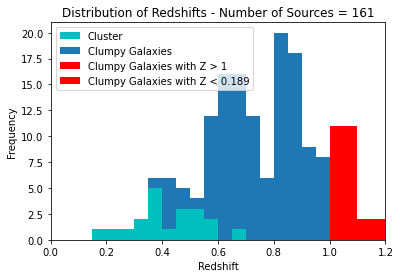

In [59]:
z_values = []
large_z_values,small_z_values = [],[]
counter = 0
count = 0

cluster_info = Table.read('/Users/brianmerino/Desktop/cluster_redshifts.txt',format='ascii')

min_z = np.min(cluster_info['z_cluster'])

for i in range(0,len(cat[magerr_col])):
    #cat['z_phot'] = zout['z_phot']
    if zout['z_phot'][i] > 1.0:
        large_z_values.append(zout['z_phot'][i])
        counter+=1
        
    elif zout['z_phot'][i] < min_z:
        small_z_values.append(zout['z_phot'][i])
        count+=1
        
    else:
        z_values.append(zout['z_phot'][i])
#cat.write('/Users/brianmerino/EAZY/galaxy_phot2.cat',format='ascii.commented_header')
bins = 20

print("Number of sources with z > 1: %s"%(counter))
print(large_z_values)
print()
print("Number of sources with z < %s: %s"%(str(min_z),count))
print(small_z_values)

plt.hist(cluster_info['z_cluster'],bins=bins,color='c',label='Cluster',zorder=10,range=(0.0,1.0))#,alpha=0.5)
plt.hist(z_values,bins=bins,label='Clumpy Galaxies',range=(0.0,1.0))
plt.hist(large_z_values,bins=bins,color='red',label='Clumpy Galaxies with Z > 1')
plt.hist(small_z_values,bins=3,color='red',label='Clumpy Galaxies with Z < %s'%(str(min_z)))
plt.title('Distribution of Redshifts - Number of Sources = %i'%(len(cat))) #excluding object with z > 2
plt.xlabel('Redshift')
plt.ylabel('Frequency')

plt.xlim(0.0,1.2)
plt.legend()


#plt.savefig('/Users/brianmerino/Desktop/z_dist.png')
plt.show()
#cluster_info.show_in_notebook()

### Diagnostic plots

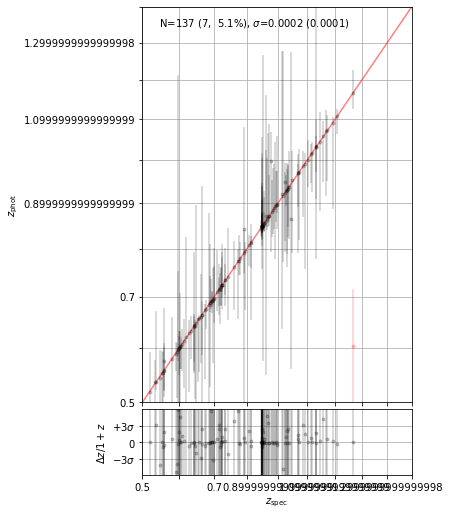

In [60]:
fig = ez.zphot_zspec(zmin=0.5, zmax=1.4, minor=0.1)

In [26]:
### UVJ
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])

uverr = 2.5*np.sqrt((zout['restU_err']/zout['restU'])**2+(zout['restV_err']/zout['restV'])**2)
vjerr = 2.5*np.sqrt((zout['restV_err']/zout['restV'])**2+(zout['restJ_err']/zout['restJ'])**2)

#Save these values to the table
#Save mass to light ratio MLv -> check that this is mass to light ratio

/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


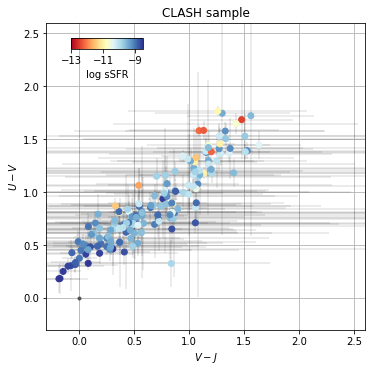

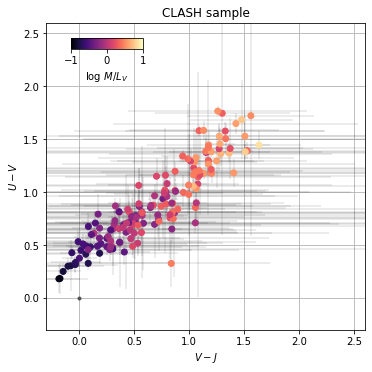

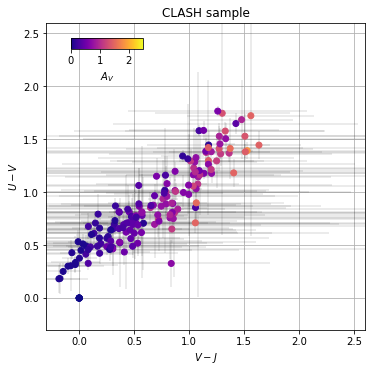

In [27]:
for show in ['ssfr', 'MLv', 'Av']:
    
    fig = plt.figure(figsize=[5,5])
    
    ax = fig.add_subplot(111)
    ax.errorbar(vj, uv, xerr=vjerr, yerr=uverr, color='k', 
                alpha=0.1, marker='.', capsize=0, linestyle='None')
    
    if show == 'ssfr':
        sc = ax.scatter(vj, uv, c=np.log10(zout['ssfr']), 
                        vmin=-13, vmax=-8.5, zorder=10, cmap='RdYlBu')
        label = 'log sSFR'
        ticks = np.arange(-13,-8,2)
    
    elif show == 'MLv':
        sc = ax.scatter(vj, uv, c=np.log10(zout['MLv']), 
                        vmin=-1, vmax=1, zorder=10, cmap='magma')
        label = r'$\log\ M/L_V$'
        ticks = np.arange(-1,1.1,1)

    elif show == 'Av':
        sc = ax.scatter(vj, uv, c=zout['Av'], vmin=0, 
                        vmax=2.5, zorder=10, cmap='plasma')
        label = r'$A_V$'
        ticks = np.arange(0,2.1,1)
    
    # Colorbar
    cax = fig.add_axes((0.18, 0.88, 0.2, 0.03))
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(label)
    cb.set_ticks(ticks)
    
    ax.set_xlim(-0.3, 2.6)
    ax.set_ylim(-0.3, 2.6)
    
    ax.grid()
    
    ax.set_xlabel(r'$V-J$'); ax.set_ylabel(r'$U-V$')
    ax.set_title('CLASH sample')
    
    fig.tight_layout(pad=0.1)
    
    plt.savefig('CLASH_sample_{0}.pdf'.format(show))

In [28]:
print('### These ids have redshifts that are too high ####')
counter=0
for j in range(0,len(cat)):
    if cat['z_eazy'][j] > 1:
        print(str(j) + '\t' + str(cat['z_eazy'][j]))
        counter+=1
print('###################################################')
print(str(counter)+' galaxies')

### These ids have redshifts that are too high ####
9	1.0305
26	1.1656
28	1.0436
49	1.1415
55	1.0013
73	1.0721
76	1.056
77	1.0162
86	1.0322
98	1.0904
121	1.1654
124	1.0664
137	1.0315
142	1.0351
144	1.1071
146	1.0135
###################################################
16 galaxies


161


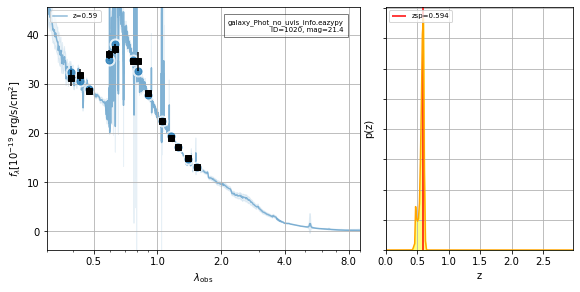

In [28]:
#for i in range(0,len(cat)):
print(len(cat))
count=0
#for i in range(0,len(cat)):
for i in range(1,2):    
    id_i = ez.cat['id'][i]
    fig = ez.show_fit(id_i,show_fnu=0)
    count+=1
    #plt.savefig('/Users/brianmerino/Desktop/Apperture_Test/%s-%s/SED.png'%(cat['cluster'],cat['id']))
    #plt.savefig('/Users/brianmerino/Downloads/a611_500_SED%i.png'%(count),facecolor='white', transparent=False)
    #fig[0].axes[0].set_ylim(0, 16)

NameError: name 'id_i' is not defined

/Users/brianmerino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


(0.0, 2.0)

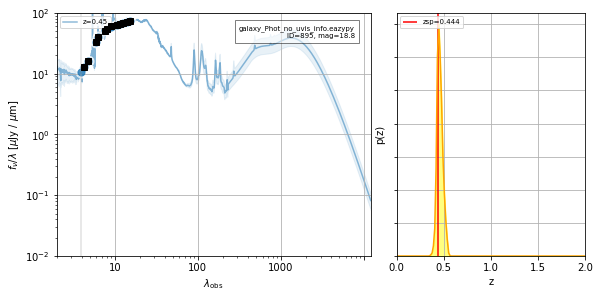

In [30]:
# nu-Fnu scaling for far-IR 
fig = ez.show_fit(id_i, show_fnu=2)

fig[0].axes[0].set_xlim(0.2, 1200)
fig[0].axes[0].set_ylim(0.01, 100)
fig[0].axes[0].loglog()
fig[0].axes[0].set_xticklabels([0.1, 1, 10, 100, 1000])
fig[0].axes[1].set_xlim(0, 2)

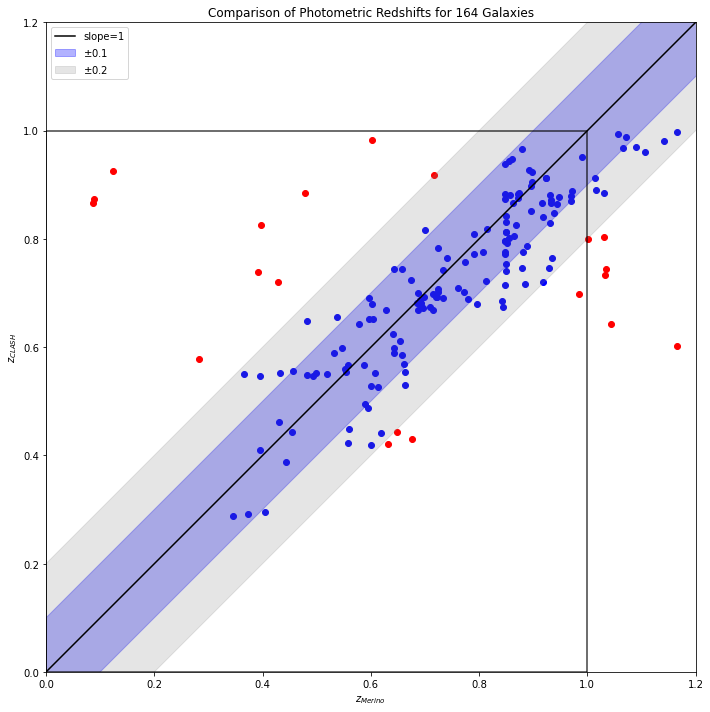

Number of galaxies: 164
The following 20 ids need to be investigated:
Cluster    id   z_merino   z_clash
a209       1772  0.48 0.88
a383       401   0.65 0.44
a383       799   0.28 0.58
a611       500   0.12 0.93
a611       769   1.17 0.60
macs0329   1903  1.04 0.64
macs0429   1424  0.39 0.74
macs0744   935   0.40 0.83
macs1115   511   1.00 0.80
macs1149   1005  0.60 0.98
macs1149   283   0.09 0.87
macs1311   307   1.03 0.73
macs1311   487   0.43 0.72
macs1423   90    0.09 0.87
rxj1347    240   1.03 0.80
rxj1347    452   0.98 0.70
rxj1532    1210  1.04 0.74
rxj2129    246   0.63 0.42
rxj2129    259   0.72 0.92
rxj2129    597   0.68 0.43


In [31]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

#cluster = 'a209'

UVIS = 0 # 0 if UVIS filters were left out of analysis

catalog_file = '/Users/brianmerino/EAZY/galaxy_phot2.cat'
catalog = Table.read(catalog_file,format = 'ascii')

start = 0
end   = 1.5


x = np.linspace(start,end,10)
y = np.linspace(start,end,10)


plt.figure(figsize=(10,10)) #fig size same as before
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)


bad_ids,bad_clusters = [],[]
bad_clash,bad_merino = [],[]

for j in range(0,len(catalog)):
    phot = catalog['z_phot'][j] 
    zb = catalog['zb'][j]
    
    if phot > zb+0.2 or phot < zb-0.2:
        plt.scatter(catalog['z_phot'][j],catalog['zb'][j],c='r')
        bad_ids.append(catalog['id'][j])
        bad_clusters.append(catalog['cluster'][j])
        bad_clash.append(catalog['zb'][j])
        bad_merino.append(catalog['z_phot'][j])
    else:
        plt.scatter(catalog['z_phot'][j],catalog['zb'][j],c='b')
        

plt.plot(x,y,label='slope=1',c='black')
plt.fill_between(x,y-0.1,y+0.1,color='blue',alpha=0.3,label='$\pm$0.1')
plt.fill_between(x,y-0.2,y+0.2,color='gray',alpha=0.2,label='$\pm$0.2')
plt.xlabel('$z_{Merino}$')
plt.ylabel('$z_{CLASH}$')

alpha = 0.75
plt.hlines(0,0,1,color='black',alpha=alpha)
plt.vlines(0,0,1,color='black',alpha=alpha)
plt.hlines(1,0,1,color='black',alpha=alpha)
plt.vlines(1,0,1,color='black',alpha=alpha)

plt.legend(loc=2)
#plt.ylim(start,1.5)
ax.set_xlim([0, 1.2])
ax.set_ylim([0, 1.2])

plt.title('Comparison of Photometric Redshifts for %s Galaxies'%(len(catalog)))
plt.tight_layout()
plt.savefig('/Users/brianmerino/Downloads/z_vs_z.png')
plt.show()


print('Number of galaxies: %s'%(len(catalog)))
print('The following %s ids need to be investigated:'%(len(bad_ids)))
print('%7s    %1s   %s   %1s'%('Cluster','id','z_merino','z_clash'))

    
for n in range(0,len(bad_ids)):
    print('%-10s'%(bad_clusters[n]),'%-5i'%(bad_ids[n]),\
          '%.2f'%(bad_merino[n]),'%.2f'%(bad_clash[n]))

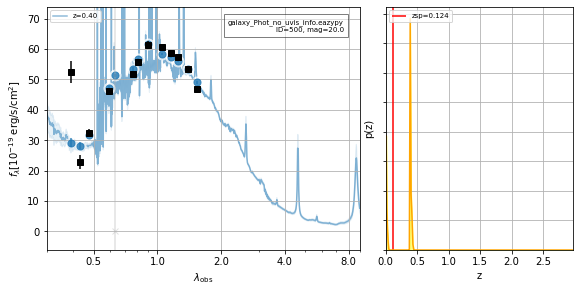

In [32]:
id_i = ez.cat['id'][24]
fig = ez.show_fit(id_i,show_fnu=0)
plt.savefig('/Users/brianmerino/Downloads/SED.png')


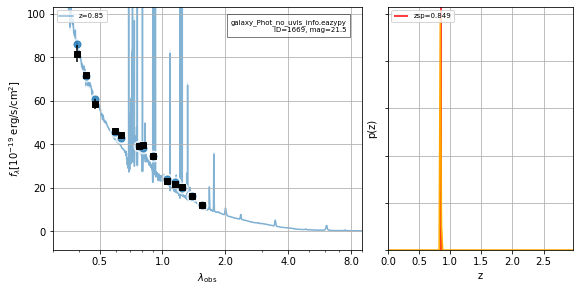

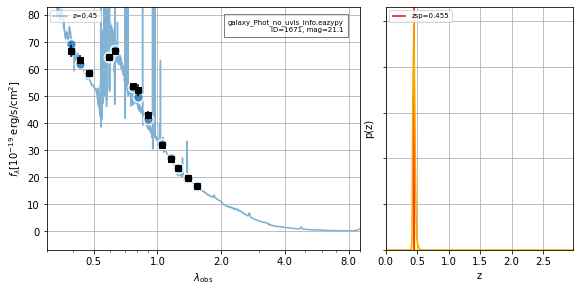

In [33]:
#for i in range(0,len(cat)):
for i in range(4,6):
    id_i = ez.cat['id'][i]
    fig = ez.show_fit(id_i,show_fnu=0)
plt.savefig('/Users/brianmerino/Downloads/SED.png')
    #fig[0].axes[0].set_ylim(0, 16)

In [34]:
#This cell prints the name of each cluster along with its coordinates
cluster_name = 'none'
counter = 0
print('#############################')
print('#%-8s %-9s %-8s#'%('Cluster','RA','DEC'))
print('#############################')
for c in range(0,len(cat['cluster'])):
    if cluster_name != cat['cluster'][c]:
        cluster_name = cat['cluster'][c]
        print('%-8s %f %f'%(cluster_name,cat['RA'][c],cat['DEC'][c]))
        counter +=1
#print(counter)    
    

#############################
#Cluster  RA        DEC     #
#############################
a209     22.973038 -13.597318
a383     42.015583 -3.508325
a611     120.224554 36.053051
macs0329 52.434917 -2.204998
macs0416 64.024571 -24.073642
macs0429 67.386437 -2.891523
macs0717 109.376738 37.753479
macs0744 116.226392 39.461100
macs1115 168.946854 1.506416
macs1149 177.396887 22.398070
macs1206 181.571475 -8.807194
macs1311 197.772604 -3.177227
macs1423 215.969846 24.076751
macs1720 260.076871 35.627610
macs1931 292.967358 -26.583314
macs2129 322.368067 -7.693056
ms2137   325.073754 -23.665161
rxj1347  206.882121 -11.736369
rxj1532  233.226529 30.341465
rxj2129  322.403642 0.087961


In [35]:
#This cell prints out the photo z and the 2.5th and 50th percentiles
count=0
print('%-10s %-10s %-10s %-10s'%('z_phot','z_160','z_500','z_840'))
for t in range(0,len(zout['z_phot'])):
    print('%-10f %-10f %-10f %-10f'%(zout['z_phot'][t],zout['z160'][t],zout['z500'][t],zout['z840'][t]))
    count+=1
print()
print(count)



z_phot     z_160      z_500      z_840     
0.849349   0.825614   0.865762   0.901801  
0.592946   0.535974   0.581076   0.603443  
0.588430   0.567807   0.587115   0.602540  
0.396545   0.321191   0.371510   0.401144  
0.848364   0.840405   0.845177   0.852298  
0.447149   0.435454   0.449664   0.468593  
0.695907   0.666565   0.698765   0.736506  
0.480841   0.472429   0.576694   0.688686  
0.405261   0.310986   0.458678   0.627380  
1.033607   0.890654   1.074348   1.527624  
0.403064   0.283783   0.431082   0.625743  
0.648221   0.445468   0.623696   0.798979  
0.570305   0.371752   0.561122   0.761478  
0.842905   0.606274   0.796915   0.971407  
0.484710   0.347014   0.516864   0.699514  
0.664652   0.451573   0.644353   0.829462  
0.920499   0.746549   0.925657   1.105787  
0.871440   0.663629   0.856618   1.025884  
0.620411   0.378420   0.570686   0.746653  
0.865290   0.670265   0.886120   1.084090  
0.345628   0.259221   0.395585   0.565227  
0.851717   0.675907   0.881266  

In [36]:
#cat.add_column(-99.99,name='z_160')
#cat.add_column(-99.99,name='z_500')
#cat.add_column(-99.99,name='z_840')

for t in range(0,len(zout['z_phot'])):
    cat['z_160'][t] = round(zout['z160'][t],4)
    cat['z_500'][t] = round(zout['z500'][t],4)
    cat['z_840'][t] = round(zout['z840'][t],4)   
    
cat.show_in_notebook()

idx,cluster,id,RA,DEC,z_clash,f225w_mag,f225w_magerr,f275w_mag,f275w_magerr,f336w_mag,f336w_magerr,f390w_mag,f390w_magerr,f435w_mag,f435w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f160w_mag,f160w_magerr,z_phot,z_eazy,z_conner,z_160,z_500,z_840,z_spec,AMP_160,AMP_best,AMP_840,spec,ra_sexagesimal,dec_sexagesimal,f225w_flux_best,f225w_fluxerr_best,f225w_flux_16,f225w_fluxerr_16,f225w_flux_84,f225w_fluxerr_84,f275w_flux_best,f275w_fluxerr_best,f275w_flux_16,f275w_fluxerr_16,f275w_flux_84,f275w_fluxerr_84,f336w_flux_best,f336w_fluxerr_best,f336w_flux_16,f336w_fluxerr_16,f336w_flux_84,f336w_fluxerr_84,f390w_flux_best,f390w_fluxerr_best,f390w_flux_16,f390w_fluxerr_16,f390w_flux_84,f390w_fluxerr_84,f435w_flux_best,f435w_fluxerr_best,f435w_flux_16,f435w_fluxerr_16,f435w_flux_84,f435w_fluxerr_84,f475w_flux_best,f475w_fluxerr_best,f475w_flux_16,f475w_fluxerr_16,f475w_flux_84,f475w_fluxerr_84,f606w_flux_best,f606w_fluxerr_best,f606w_flux_16,f606w_fluxerr_16,f606w_flux_84,f606w_fluxerr_84,f625w_flux_best,f625w_fluxerr_best,f625w_flux_16,f625w_fluxerr_16,f625w_flux_84,f625w_fluxerr_84,f775w_flux_best,f775w_fluxerr_best,f775w_flux_16,f775w_fluxerr_16,f775w_flux_84,f775w_fluxerr_84,f814w_flux_best,f814w_fluxerr_best,f814w_flux_16,f814w_fluxerr_16,f814w_flux_84,f814w_fluxerr_84,f850lp_flux_best,f850lp_fluxerr_best,f850lp_flux_16,f850lp_fluxerr_16,f850lp_flux_84,f850lp_fluxerr_84,f105w_flux_best,f105w_fluxerr_best,f105w_flux_16,f105w_fluxerr_16,f105w_flux_84,f105w_fluxerr_84,f110w_flux_best,f110w_fluxerr_best,f110w_flux_16,f110w_fluxerr_16,f110w_flux_84,f110w_fluxerr_84,f125w_flux_best,f125w_fluxerr_best,f125w_flux_16,f125w_fluxerr_16,f125w_flux_84,f125w_fluxerr_84,f140w_flux_best,f140w_fluxerr_best,f140w_flux_16,f140w_fluxerr_16,f140w_flux_84,f140w_fluxerr_84,f160w_flux_best,f160w_fluxerr_best,f160w_flux_16,f160w_fluxerr_16,f160w_flux_84,f160w_fluxerr_84
0,a209,218,22.9730375,-13.5973175,0.939,21.022,0.025,-99.0,-99.0,22.711,0.068,24.107,0.13,24.274,0.114,24.094,0.068,23.743,0.033,23.941,0.068,22.948,0.034,22.67,0.02,22.769,0.06,22.679,0.015,22.58,0.008,22.393,0.012,22.3,0.009,22.298,0.014,0.8485,0.8485,0.903,0.8256000280380249,0.8658000230789185,0.9017999768257141,0.8485,1.2121,1.2149,1.2196,0.0,01:31:53.529,-13:35:50.34,11.658950755111643,0.2684572620867175,11.685883402677284,0.26907740921471257,11.61402039388745,0.26742270228694087,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.4607045253227318,0.15411469838497427,2.466388852251949,0.15447070956843928,2.451221652848956,0.15352078309929915,0.6802357739038563,0.08144763914103895,0.6818071460405867,0.0816357864800332,0.6776143339749058,0.08113376253890475,0.5832563395479197,0.06124067928938149,0.5846036852708255,0.06138214773423775,0.581008631450285,0.06100467470373038,0.6884294934431013,0.04311655570568315,0.6900197934032043,0.04321615669238055,0.6857764771925418,0.04295039646345889,0.9511728993350307,0.028910066313067737,0.9533701471843321,0.02897684973496081,0.9475073429010568,0.0287986549391161,0.7926098551086965,0.049641404524589997,0.7944408159158118,0.0497560781758307,0.7895553566509966,0.04945010032545456,1.978151127609877,0.061946113654484575,1.9827207366828148,0.06208921168124191,1.9705278820377499,0.06170739052052584,2.555403397916163,0.04707227016502472,2.56130648306934,0.04718100901203576,2.5455555822633213,0.04689086669685842,2.3327031076706697,0.12890993765048084,2.3380917461505626,0.12920772481772888,2.323713517144225,0.12841315451916135,2.534308428464574,0.03501276485059017,2.5401627833855382,0.03509364575281083,2.524541906970819,0.03487783536977861,2.7762557301742445,0.02045620818764325,2.7826689931430493,0.020503462855513396,2.76555681091234,0.020377375637231705,3.2980669535123086,0.036451583053697896,3.3056856215016124,0.03653578768413298,3.2853571185815875,0.03631110876675761,3.5930186207

In [ ]:
#cat.remove_columns(['z_160','z_500','z_840'])
cat.write(file,format='ascii.commented_header')

In [ ]:
#This cell opens a catalog I created of my clumpy galaxies that Tom has spec z's for
spec_path = 'galaxy_spec_z.cat'
test = Table.read(spec_path,format='ascii.commented_header')


for t in range(0,len(test)):
    if test['z_spec_conner'][t] > 1.1984:
        print('%s %i %f'%(test['cluster'][t],test['id'][t],test['z_spec_conner'][t]))
test.show_in_notebook()


In [ ]:
spec_z,phot_z = [],[]

x_min,x_max = 0.0,1.3
y_min,y_max = 0.0,1.3

for n in range(0,len(test)):
    spec_z.append(test['z_spec_conner'][n])
    phot_z.append(test['z_eazy'][n])
    
plt.scatter(phot_z,spec_z)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

In [ ]:
#spec_z,phot_z = [],[]

start = 0
end   = 1.5

x = np.linspace(start,end,10)
y = np.linspace(start,end,10)

plt.figure(figsize=(10,10)) #fig size same as before
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)

bad_ids,bad_clusters = [],[]
bad_clash,bad_merino = [],[]

for j in range(0,len(test)):
    phot = test['z_eazy'][j] 
    spec = test['z_spec_conner'][j]
    
    if phot > spec+0.2 or phot < spec-0.2:
        plt.scatter(test['z_eazy'][j],test['z_spec_conner'][j],c='r')
        bad_ids.append(test['id'][j])
        bad_clusters.append(test['cluster'][j])
        bad_clash.append(test['z_spec_conner'][j])
        bad_merino.append(test['z_eazy'][j])
    else:
        plt.scatter(test['z_eazy'][j],test['z_spec_conner'][j],c='b')
        

plt.plot(x,y,label='slope=1',c='black')
plt.fill_between(x,y-0.1,y+0.1,color='blue',alpha=0.3,label='$\pm$0.1')
plt.fill_between(x,y-0.2,y+0.2,color='gray',alpha=0.2,label='$\pm$0.2')
plt.xlabel('$z_{Merino\ phot}$')
plt.ylabel('$z_{Conner\ spec}$')

alpha = 0.75
plt.hlines(0,0,1,color='black',alpha=alpha)
plt.vlines(0,0,1,color='black',alpha=alpha)
plt.hlines(1,0,1,color='black',alpha=alpha)
plt.vlines(1,0,1,color='black',alpha=alpha)

plt.legend(loc=2)
#plt.ylim(start,1.5)
ax.set_xlim([0, 1.3])
ax.set_ylim([0, 1.3])

plt.title('Comparison of Redshifts for %s Galaxies'%(len(test)))
plt.tight_layout()
plt.savefig('/Users/brianmerino/Downloads/z_photvs_z_spec.png',facecolor='white', transparent=False)
plt.show()


print('Number of galaxies: %s'%(len(test)))
print('The following %s ids need to be investigated:'%(len(bad_ids)))
print('%7s    %1s   %s   %1s'%('Cluster','id','z_merino','z_clash'))

    
for n in range(0,len(bad_ids)):
    print('%-10s'%(bad_clusters[n]),'%-5i'%(bad_ids[n]),\
          '%.2f'%(bad_merino[n]),'%.2f'%(bad_clash[n]))

2


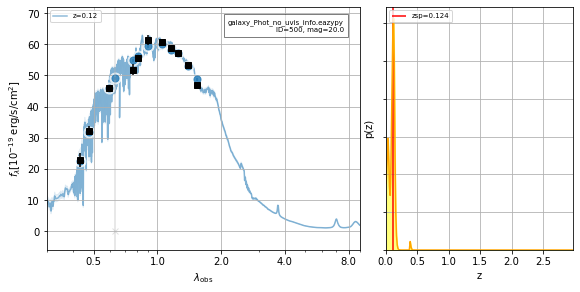

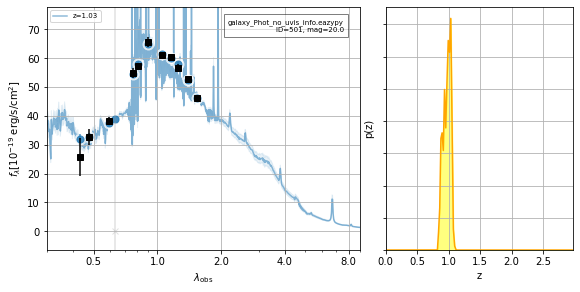

In [15]:
#for i in range(0,len(cat)):
print(len(cat))
count=0
for i in range(0,2):
    id_i = ez.cat['id'][i]
    fig = ez.show_fit(id_i,show_fnu=0)
    count+=1
    #plt.savefig('/Users/brianmerino/Desktop/Apperture_Test/%s-%s/SED.png'%(cat['cluster'],cat['id']))
    #plt.savefig('/Users/brianmerino/Downloads/a611_500_SED%i.png'%(count),facecolor='white', transparent=False)
    #fig[0].axes[0].set_ylim(0, 16)

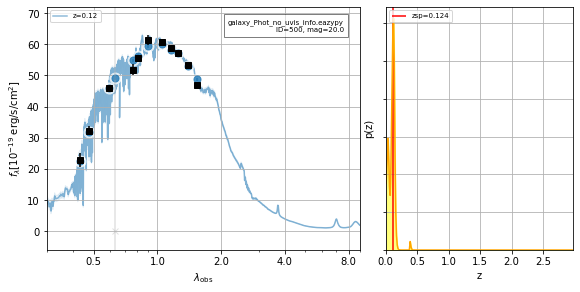

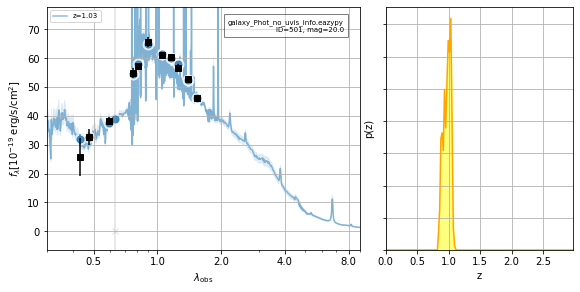

In [24]:
#ez.show_fit((ez.cat['id'][0],ez.cat['id'][1]),show_fnu=0)
ax1 = ez.show_fit(ez.cat['id'][0],show_fnu=0)
ax2 = ez.show_fit(ez.cat['id'][1],show_fnu=0)